In [63]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")

import numpy as np

%matplotlib widget

In [64]:
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from weyl_decompose import RootiSwapWeylDecomposition as decomposer
from qiskit.transpiler.passes import Collect2qBlocks, ConsolidateBlocks, Unroll3qOrMore, Optimize1qGates
from src.utils.custom_gates import RiSwapGate
from qiskit.circuit.library import CXGate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator
from src.basis import MixedOrderBasisCircuitTemplate
from src.utils.polytope_wrap import monodromy_range_from_target
from src.scripts.gate_exploration.bgatev2script import get_group_name, cost_scaling, pick_winner
from qiskit.transpiler.basepasses import AnalysisPass
from qiskit.transpiler.passes import CountOps
from qiskit.dagcircuit import DAGOpNode, DAGCircuit
from qiskit.transpiler import PassManager

In [65]:
class pass_manager_basic(PassManager):
    def __init__(self, gate='iswap'):
        passes = []
        # collect 2Q blocks
        passes.extend([Unroll3qOrMore(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])
        if gate == 'iswap':
            passes.extend([decomposer(basis_gate=RiSwapGate(1/2))])
        elif gate == 'cx':
            passes.extend([decomposer(basis_gate=CXGate())])
        #combine 1Q gates
        passes.extend([Optimize1qGates()])
        #passes.extend([CountOps(), fooAnalysis()])
        super().__init__(passes)

In [66]:
#transp1 = transpile(qc, optimization_level=3, basis_gates=['u', 'id', 'cx'])
pm = pass_manager_basic(gate='iswap')
qc = QuantumCircuit(2)
qc.swap(0,1)
transp1 = pm.run(qc)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.10943 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.37003 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 2.85339 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RootiSwapWeylDecomposition - 20.30754 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 4.31895 (ms)


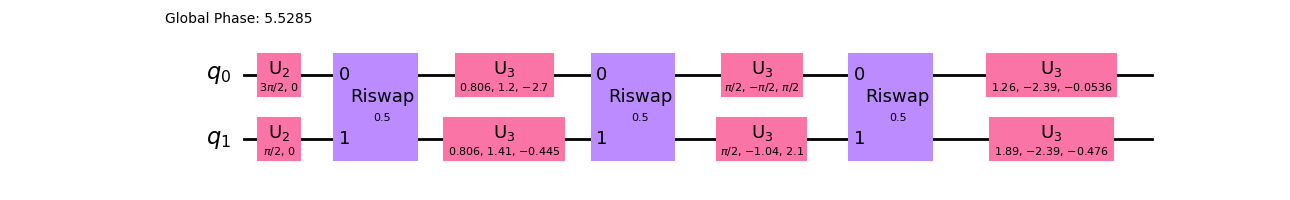

In [67]:
transp1.draw(output='mpl');

In [93]:
from src.basisv2 import CircuitTemplateV2
basis = CircuitTemplateV2(n_qubits=2, base_gates = [RiSwapGate], edge_params=[[(0,1)]])
basis.build(3)
basis.spanning_range = range(3,4)

#bound all Qs to be >0
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, 0.5, 0.5)

from src.sampler import HaarSample, GateSample
from qiskit.circuit.library import CXGate, CZGate, SwapGate
sampler = GateSample(gate = SwapGate())
s = [s for s in sampler][0]

from src.optimizer import TemplateOptimizer
from src.cost_function import BasicCostInverse, BasicCost
objective1 = BasicCost()
optimizer3 = TemplateOptimizer(basis=basis, objective=objective1, use_callback=False, override_fail=True, success_threshold = 1e-7, training_restarts=25)
_ret3 = optimizer3.approximate_target_U(s)

INFO:root:Begin search: (0.5, 0.5, 0.5)
INFO:root:Starting opt on template size 3
  0%|          | 0/25 [00:15<?, ?it/s]
INFO:root:Cycle (k =3), Best Loss=8.728064271323888e-09
INFO:root:Break on cycle 3
INFO:root:Overall Best Loss=8.728064271323888e-09
INFO:root:Success: (0.5, 0.5, 0.5)


In [94]:
basis.build(_ret3.cycles)
circuit =basis.assign_Xk(_ret3.Xk)
transp1 = circuit
circuit.draw()

┌────────────────────────────────────────────────────────┐»
q_0: ─┤ U(-10.9078313957527,10.8829188160537,8.86445375881233) ├»
     ┌┴────────────────────────────────────────────────────────┤»
q_1: ┤ U(10.8229389787973,-5.11904497069474,-8.86078024401412) ├»
     └─────────────────────────────────────────────────────────┘»
«     ┌──────────────┐»
«q_0: ┤0             ├»
«     │  Riswap(0.5) │»
«q_1: ┤1             ├»
«     └──────────────┘»
«      ┌───────────────────────────────────────────────────────┐ »
«q_0: ─┤ U(-4.724557060246,-9.5496038113911,-2.65705670020938) ├─»
«     ┌┴───────────────────────────────────────────────────────┴┐»
«q_1: ┤ U(-1.58309443441012,3.03173867179458,-8.95740798552819) ├»
«     └─────────────────────────────────────────────────────────┘»
«     ┌──────────────┐»
«q_0: ┤0             ├»
«     │  Riswap(0.5) │»
«q_1: ┤1             ├»
«     └──────────────┘»
«     ┌────────────────────────────────────────────────────────┐»
«q_0: ┤ U(7.86629623032573,-9.7756008747816,-10.8709601258258) ├»
«     ├────────────────────────────────────────────────────────┤»
«q_1: ┤ U(7.84195190369169,5.94967528477969,-7.74434170781597) ├»
«     └────────────────────────────────────────────────────────┘»
«     ┌──────────────┐»
«q_0: ┤0             ├»
«     │  Riswap(0.5) │»
«q_1: ┤1             ├»
«     └──────────────┘»
«     ┌─────────────────────────────────────────────────────────┐
«q_0: ┤ U(0.173060629858153,9.21969076958505,-1.57322090571431) ├
«     ├─────────────────────────────────────────────────────────┤
«q_1: ┤ U(3.52061077707819,-10.6280535000656,-6.16088283305632) ├
«     └─────────────────────────────────────────────────────────┘

In [95]:
c1c2c3(Operator(transp1).data)

(0.50002988, 0.49995774, 0.49994018)

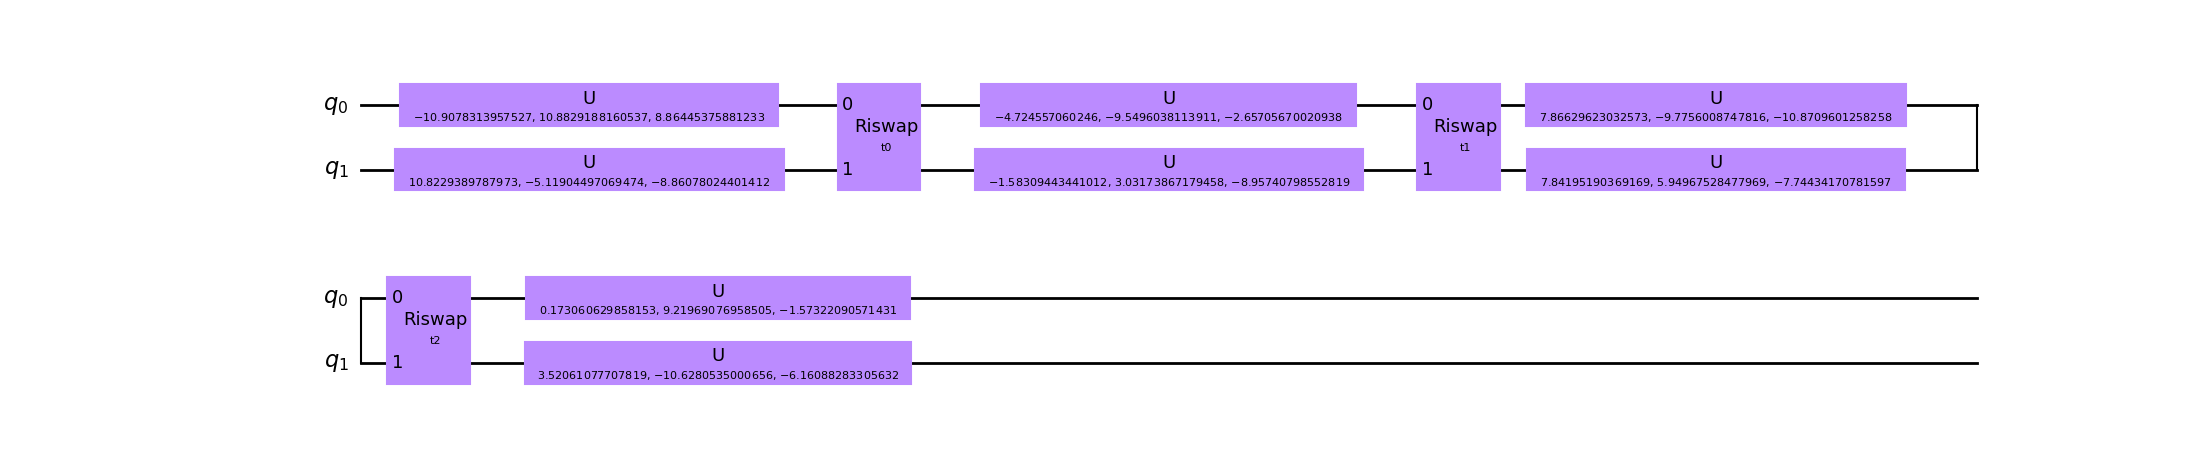

In [96]:
from qiskit.circuit import Parameter
def unbind_parameters(qc):
    i = 0
    out = qc.copy()
    for instr, qargs, cargs in out:
        if instr.params and instr.name =="riswap":
            # num_params = len(instr.params)
            # pvec.resize(len(pvec) + num_params)
            instr.params = [Parameter(f't{i}')]
            i +=1
    return out

transp1 = unbind_parameters(transp1)
transp1.draw(output='mpl');

In [101]:
from weylchamber import c1c2c3
endpoints = [5,8,11]
coordinate_list = []

for end in endpoints:
    qc = QuantumCircuit(2)
    for gate in transp1[0:end]:
        qc.append(gate[0], gate[1])

    # 2, 5, 8
    qc2 = qc.copy()
    for i in [2,5,8]:
        if i < end-3:
            qc2 = qc2.bind_parameters({qc2[i][0].params[0] : 0.5} )
    for t in np.linspace(0,.5, 25):
        qc3 = qc2.bind_parameters({qc2[end-3][0].params[0]: t})

        #eliminating x-axis symmetry
        c = list(c1c2c3(Operator(qc3).data))
        if c[0] > 0.5:
            c[0] = -1*c[0] + 1


        coordinate_list.append(c)

# qc2.draw(output='mpl');

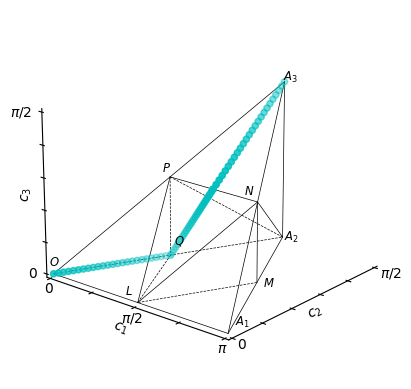

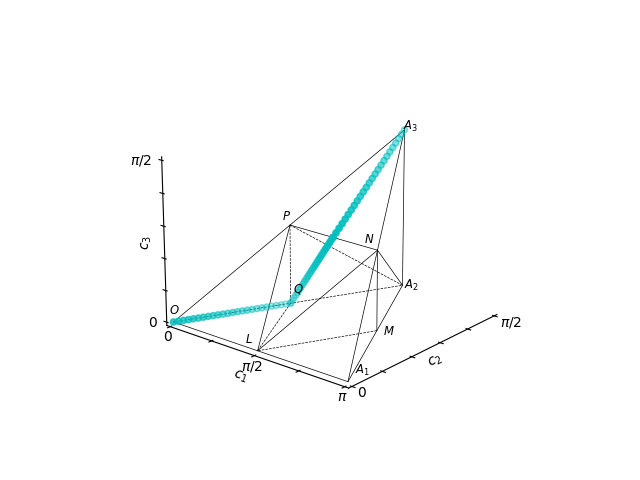

In [102]:
from src.utils.visualize import coordinate_2dlist_weyl
coordinate_2dlist_weyl(coordinate_list)